# IBM Data Science Specialisation - Capstone Project Notebook
This notebook provides code and details for Week 4 and 5 of the 'Applied Data Science Capstone' course as part of the IBM Data Science specialisation. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup

import geocoder as gc

import folium
from html import escape, unescape
import requests 
from pandas.io.json import json_normalize

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

## Get the 20 largest cities in Germany, including location and population size, from Wikipedia

In [2]:
path = "C:\\Users\\schuetzenberger\\Documents\\main\\COURSES\\IBM Data Science\\Capstone\\German_cities_population.html"

In [3]:
# read the html
with open(path, 'rb') as fp:
    soup = BeautifulSoup(fp)

In [4]:
# get the table element
table = soup.find_all("table")[0]

In [5]:
# read all rows in the table, and then all elements in a row into a nested list
rs = []
for row in table.find_all('tr'):
    r = []
    for i in row.find_all('td'):
        temptext = i.text[:-1]
        if temptext[-1] == '\r':
            r.append(temptext[:-1])
        else:
            r.append(temptext[:])
    rs.append(r)

In [6]:
# convert the nested list into a pandas datafram 
df = pd.DataFrame(rs, columns = ['Rank', 'City', 'State', '2015 pop', '2011', 'Change', '2015 area', '2015 density', 'Location'])

In [7]:
df

,Rank,City,State,2015 pop,2011,Change,2015 area,2015 density,Location
0,None,None,None,None,None,None,None,None,None
1,1,Berlin,Berlin,"3,520,031","3,292,365",+6.91%,891.68 km2344.28 sq mi,"3,948/km210,230/sq mi",52°31′N 13°23′E﻿ / ﻿52.517°N 13.383°E﻿ / 52.51...
2,2,Hamburg,Hamburg,"1,787,408","1,706,696",+4.73%,755.3 km2291.6 sq mi,"2,366/km26,130/sq mi",53°33′N 10°0′E﻿ / ﻿53.550°N 10.000°E﻿ / 53.550...
3,3,Munich (München),Bavaria,"1,450,381","1,348,335",+7.57%,310.7 km2120.0 sq mi,"4,668/km212,090/sq mi",48°8′N 11°34′E﻿ / ﻿48.133°N 11.567°E﻿ / 48.133...
4,4,Cologne (Köln),North Rhine-Westphalia,"1,060,582","1,005,775",+5.45%,405.02 km2156.38 sq mi,"2,619/km26,780/sq mi",50°56′N 6°57′E﻿ / ﻿50.933°N 6.950°E﻿ / 50.933;...
5,5,Frankfurt am Main,Hesse,"732,688","667,925",+9.70%,248.31 km295.87 sq mi,"2,951/km27,640/sq mi",50°7′N 8°41′E﻿ / ﻿50.117°N 8.683°E﻿ / 50.117; ...
6,6,Stuttgart,Baden-Württemberg,"623,738","585,890",+6.46%,207.35 km280.06 sq mi,"3,008/km27,790/sq mi",48°47′N 9°11′E﻿ / ﻿48.783°N 9.183°E﻿ / 48.783;...
7,7,Düsseldorf,North Rhine-Westphalia,"612,178","586,291",+4.42%,217.41 km283.94 sq mi,"2,816/km27,290/sq mi",51°14′N 6°47′E﻿ / ﻿51.233°N 6.783°E﻿ / 51.233;...
8,8,Dortmund,North Rhine-Westphalia,"586,181","571,143",+2.63%,280.71 km2108.38 sq mi,"2,088/km25,410/sq mi",51°31′N 7°28′E﻿ / ﻿51.517°N 7.467°E﻿ / 51.517;...
9,9,Essen,North Rhine-Westphalia,"582,624","566,201",+2.90%,210.34 km281.21 sq mi,"2,770/km27,200/sq mi",51°27′N 7°1′E﻿ / ﻿51.450°N 7.017°E﻿ / 51.450; ...


In [8]:
# remove first row of None entries
df.drop(0, inplace = True)

In [9]:
# pick only relevant columns
df = df[['City', '2015 pop', '2015 area', 'Location']]

In [10]:
# pick the first 20 cities 
df = df[0:20]

In [11]:
#functions to convert strings into floats
def split_at_km(text):
    return float(text.split()[0])

def get_latitude(text):
    return float(text.split()[3][1:-2])

def get_longitude(text):
    return float(text.split()[4][:-3])

def population_to_float(text):
    return float(text.replace(',',''))

In [12]:
# convert strings into floats
df['area_km2'] = df['2015 area'].apply(split_at_km) 
df['Latitude'] = df['Location'].apply(get_latitude) 
df['Longitude'] = df['Location'].apply(get_longitude) 
df['2015 pop'] = df['2015 pop'].apply(population_to_float) 

In [13]:
# remove unused columns
df = df.drop(columns = ['Location','2015 area'])

In [14]:
# calculate the radius of a city (assuming that the cities are circular)
df['Radius'] = np.sqrt(df['area_km2']/np.pi)*1000

# Make the City column the index
df.set_index("City", inplace = True)

In [15]:
# show the cities on a map of Germany, the size of the marker corresponding to the population size 
latitude = df['Latitude'].mean()
longitude = df['Longitude'].mean()
map_germany = folium.Map(location=[latitude, longitude], zoom_start=6)

for lat, lng, city,rad in zip(df['Latitude'], df['Longitude'], df.index, df['Radius']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=rad/1000.,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_germany)  
    
map_germany

In [16]:
df

,2015 pop,area_km2,Latitude,Longitude,Radius
City,,,,,
Berlin,3520031.0,891.68,52.517,13.383,16847.271569
Hamburg,1787408.0,755.30,53.550,10.000,15505.465392
Munich (München),1450381.0,310.70,48.133,11.567,9944.791684
Cologne (Köln),1060582.0,405.02,50.933,6.950,11354.376694
Frankfurt am Main,732688.0,248.31,50.117,8.683,8890.417754
Stuttgart,623738.0,207.35,48.783,9.183,8124.134102
Düsseldorf,612178.0,217.41,51.233,6.783,8318.879273
Dortmund,586181.0,280.71,51.517,7.467,9452.659316
Essen,582624.0,210.34,51.450,7.017,8182.499707


## Use the Foursquare API to explore venues of specific categories in those cities

In [17]:
# Foursquare credentials

CLIENT_ID = 'L3WPUO2ZAF3LLZT1LZQ01MKA14AJT2XZSCYIJ2S1LAPNQGPL' # your Foursquare ID
CLIENT_SECRET = 'LQGKSTXFJ5GNDLST4FGHUO3AEMPRZRFEADDVZTFKJSJWVTXG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)


Your credentails:
CLIENT_ID: L3WPUO2ZAF3LLZT1LZQ01MKA14AJT2XZSCYIJ2S1LAPNQGPL


#### Specify categories of interest
Here, the user can specify the venues of interest. The category IDs and names are taken from the category tree of the Foursquare API: https://developer.foursquare.com/docs/build-with-foursquare/categories/

In [18]:

#'4bf58dd8d48988d1e7931735' #Jazz Club
#'4bf58dd8d48988d137941735' #Theatre
#'4bf58dd8d48988d1f5931735' # Dim Sum Restaurant
#'4bf58dd8d48988d156941735' #Malay Restaurant
#'52e81612bcbc57f1066b7a0c' #Bubble Tea shop
#'4bf58dd8d48988d1c2941735' # Molecular Gastronomy Restaurant
#'4bf58dd8d48988d11f941735' #NIght club
#'52f2ab2ebcbc57f1066b8b17' #Costume shop
#'4bf58dd8d48988d134941735' #Dance studio
category_names = ['Jazz Club', 'Theater', 'Dim Sum Restaurant', 'Malay Restaurant','Bubble Tea Shop', 'Molecular Gastronomy Restaurant', 'Nightclub', 'Costume shop', 'Dance studio']
categories = ['4bf58dd8d48988d1e7931735','4bf58dd8d48988d137941735', '4bf58dd8d48988d1f5931735', '4bf58dd8d48988d156941735','52e81612bcbc57f1066b7a0c','4bf58dd8d48988d1c2941735','4bf58dd8d48988d11f941735','52f2ab2ebcbc57f1066b8b17','4bf58dd8d48988d134941735']

In [19]:
len(category_names)

9

#### Send the query to the Foursquare API

The next box is commented out since I already store the data on the local machine. If the query should be re-run, uncomment the box.

In [25]:
# LIMIT = 1000 # The actual limit given by the Foursquare API for the 'explore' query is only 100, so it will never return more than 100 venues]

# res_city = pd.DataFrame(columns = ['venue.name', 'venue.categories','venue.location.lat','venue.location.lng','venue.location.distance', 'Category', 'City'])

# # Loop for each city
# for i in np.arange(20,0,-1):
#     radius = df['Radius'][i]
#     latitude = df['Latitude'][i]
#     longitude = df['Longitude'][i]
#     print(df['City'][i], radius, latitude, longitude)
    
#     # Query separately for each category
#     for  c in categories:
#         url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, c, LIMIT)
#         #retreiving the venue list
#         results = requests.get(url)
#         results = results.json()['response']['groups'][0]['items']
        
#         # add the resulting dataframe to the complete dataframe
#         try:
#             nearby = json_normalize(results)[['venue.name', 'venue.categories','venue.location.lat','venue.location.lng','venue.location.distance']]
#             nearby['Category'] = c
#             nearby['City'] = df['City'][i]
#             if nearby.shape[0] > 99: # Warn if there were probaby more than 100 venues, but Foursquare will only return the first 100, biasing our results 
#                 print(df['City'][i], c, "WARNING, more than 99 venues found")
#             res_city = res_city.append(nearby)
            
#         except KeyError: # Pass if no venues of that category were found in that city
#             pass
    

 Münster 9825.325556022051 51.967 7.633
 Bonn 6700.805365408364 50.733 7.1
 Bielefeld 9076.616370767728 52.017 8.533
 Wuppertal 7321.215864491944 51.267 7.183
 Bochum 6809.18629657986 51.483 7.217
 Duisburg 8608.28330758151 51.433 6.767
 Nuremberg (Nürnberg) 7702.376035155315 49.45 11.083
 Hanover (Hannover) 8061.003669863885 52.367 9.717
 Dresden 10225.38172459354 51.033 13.733
 Bremen 10189.520041465586 53.083 8.8
 Leipzig 9736.153455319656 51.333 12.383
 Essen 8182.499707295964 51.45 7.017
 Dortmund 9452.659316332725 51.517 7.467
 Düsseldorf 8318.879272787766 51.233 6.783
 Stuttgart 8124.134101564856 48.783 9.183
 Frankfurt am Main 8890.417753868322 50.117 8.683
 Cologne (Köln) 11354.37669368772 50.933 6.95
 Munich (München) 9944.791683957174 48.133 11.567
 Hamburg 15505.465392390422 53.55 10.0
 Berlin 16847.27156878414 52.517 13.383
 Berlin 4bf58dd8d48988d137941735 WARNING, more than 99 venues found
 Berlin 4bf58dd8d48988d11f941735 WARNING, more than 99 venues found


#### Save/reload the data if it was already queried, such that I don't run out of calls to the API

In [21]:
#res_city.to_pickle('res_city2.pkl') 
res_city = pd.read_pickle('res_city2.pkl') # Load the DF from the saved data 

## Explore the data

In [22]:
# Rename columns 
res_city.rename(columns = {'venue.name':'Name', 'venue.location.lat':'Latitude', 'venue.location.lng': 'Longitude', 'venue.location.distance':'Distance'}, inplace = True)

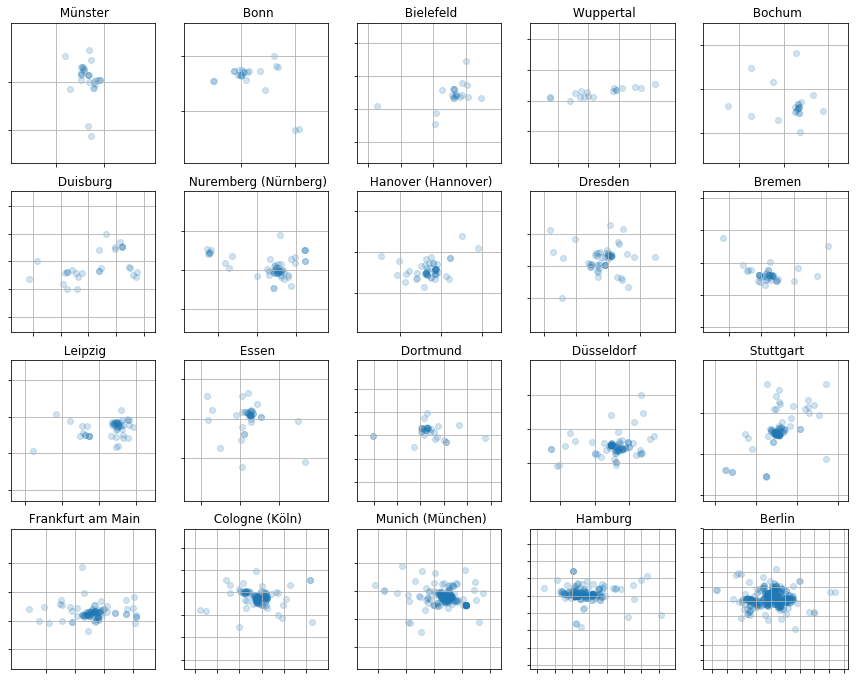

In [23]:
# Visualize for each city all venues in the specified categories. 
# The x axis is the longitude, the y axis the latitude. Grid lines are drawn each 0.05 degree 
# This plot visualizes the spatial distribution of the venues in each city. 

plt.figure(figsize = (15,15))
for c in range(20):
    city = res_city['City'].unique()[c]
    xs = res_city['Longitude'][res_city['City']==city]
    ys = res_city['Latitude'][res_city['City']==city]
    plt.subplot(5,5,c+1)
    plt.scatter(xs,ys, alpha = 0.2)
    
    xrange = xs.max() - xs.min()
    yrange = ys.max() - ys.min()
    r = np.max([xrange, yrange])*1.2
    xmin = np.mean([xs.max(), xs.min()]) - r/2.
    xmax = np.mean([xs.max(), xs.min()]) + r/2.
    ymin = np.mean([ys.max(), ys.min()]) - r/2.
    ymax = np.mean([ys.max(), ys.min()]) + r/2.
    plt.xticks(np.arange(np.round(xmin,1),np.round(xmax,2),0.05), labels = [])
    plt.yticks(np.arange(np.round(ymin,1),np.round(ymax,2),0.05), labels = [])
    plt.axis([xmin, xmax, ymin, ymax])
    plt.title(city)
    plt.axis('equal')
    plt.grid()

## Calculate relevant metrics
* The total number of venues per city 'venue_no'
* The number of venues in each category per city, stored in the df 'cat_city'
  * From this, calculate the 'diversity_score', which is given by the total number of categories (9 in this case) minus the number of categories with 0 venues in this city
* The median distance of the venues from the center, 'venue_dist'

In [24]:
# convert the Distance column into float
res_city['Distance'] = res_city['Distance'].astype(float)

In [25]:
# Create a new dataframe where the venues are grouped by city and category
# Rearrange the data frame such that city is the index, categories are the columns, 
## and entries are the number of venues 

cat_city = res_city.groupby(['City', 'Category']).count()
cat_city.reset_index(level=0, inplace=True)
cat_city.reset_index(level=0, inplace=True)
cat_city = cat_city[['City', 'Category', 'Name']]
cat_city = cat_city.pivot(index = 'City', columns = 'Category')
cat_city.replace(np.nan,0,inplace = True)

In [26]:
cat_city.head()

Name                           \
Category            4bf58dd8d48988d11f941735 4bf58dd8d48988d134941735   
City                                                                    
 Bielefeld                               8.0                      6.0   
 Hanover (Hannover)                     24.0                      8.0   
 Berlin                                100.0                     65.0   
 Bochum                                  9.0                      5.0   
 Bonn                                    6.0                      4.0   

                                                                       \
Category            4bf58dd8d48988d137941735 4bf58dd8d48988d156941735   
City                                                                    
 Bielefeld                               6.0                      0.0   
 Hanover (Hannover)                     11.0                      0.0   
 Berlin                                100.0                      3.0   
 Bochum                                  6.0                      0.0   
 Bonn                                    9.0                      0.0   

                                                                       \
Category            4bf58dd8d48988d1c2941735 4bf58dd8d48988d1e7931735   
City                                                                    
 Bielefeld                               0.0                      1.0   
 Hanover (Hannover)                      0.0                      4.0   
 Berlin                                  1.0                     18.0   
 Bochum                                  0.0                      0.0   
 Bonn                                    0.0                      1.0   

                                                                       \
Category            4bf58dd8d48988d1f5931735 52e81612bcbc57f1066b7a0c   
City                                                                    
 Bielefeld                               0.0                      0.0   
 Hanover (Hannover)                      2.0                      2.0   
 Berlin                                 32.0                     27.0   
 Bochum                                  0.0                      2.0   
 Bonn                                    2.0                      1.0   

                                              
Category            52f2ab2ebcbc57f1066b8b17  
City                                          
 Bielefeld                               0.0  
 Hanover (Hannover)                      0.0  
 Berlin                                  4.0  
 Bochum                                  0.0  
 Bonn                                    0.0

In [27]:
# calculate how many cities don't have a single venue in a specific category
# calculate the diversity score as the number of categories with at least a single venue 
diversity_score = len(categories) - (cat_city == 0).sum(axis = 1)

In [28]:
# get the median distance of the venues from the city center 
venue_dist = res_city.groupby('City').median()['Distance']

In [29]:
# get the total number of venues in each city
venue_no = res_city.groupby('City').count().sort_values('Name')
venue_no = venue_no['Name']

#### Create the DF with all the relevant metrics 

In [30]:
finaldf = pd.concat([df['2015 pop'], venue_no, venue_dist, diversity_score], axis = 1, sort = True)
finaldf = finaldf.rename(columns = {'Name':'Venue Number', 'Distance':'Median Distance', 0:'Diversity score'})

In [31]:
finaldf

,2015 pop,Venue Number,Median Distance,Diversity score
Bielefeld,333090.0,21,1428.0,4
Hanover (Hannover),532163.0,51,1942.0,6
Berlin,3520031.0,350,3679.5,9
Bochum,364742.0,22,1086.0,4
Bonn,318809.0,23,571.0,6
Bremen,557464.0,43,1160.0,7
Cologne (Köln),1060582.0,118,1358.0,7
Dortmund,586181.0,32,1261.0,7
Dresden,543825.0,55,3920.0,6
Duisburg,491231.0,28,4970.0,8


#### Expore the metrics 

(array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 8 Text yticklabel objects>)

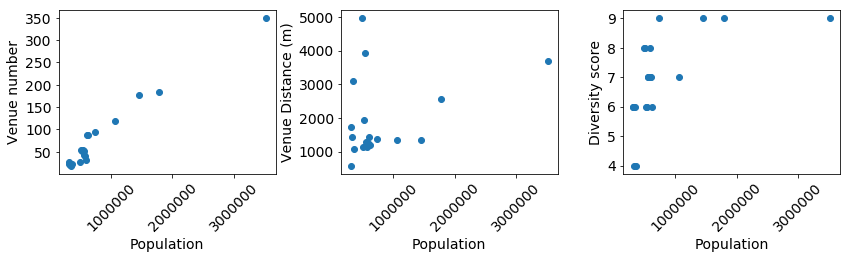

In [32]:
plt.figure(figsize = (14,3))
plt.subplots_adjust(wspace = 0.3)
plt.subplot(1,3,1)
plt.scatter(finaldf['2015 pop'], finaldf['Venue Number'])
plt.xlabel('Population', fontsize = 14)
plt.ylabel('Venue number', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.subplot(1,3,2)
plt.scatter(finaldf['2015 pop'], finaldf['Median Distance'])
plt.xlabel('Population', fontsize = 14)
plt.ylabel('Venue Distance (m)', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

plt.subplot(1,3,3)
plt.scatter(finaldf['2015 pop'], finaldf['Diversity score'])
plt.xlabel('Population', fontsize = 14)
plt.ylabel('Diversity score', fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 14)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000.]),
 <a list of 7 Text yticklabel objects>)

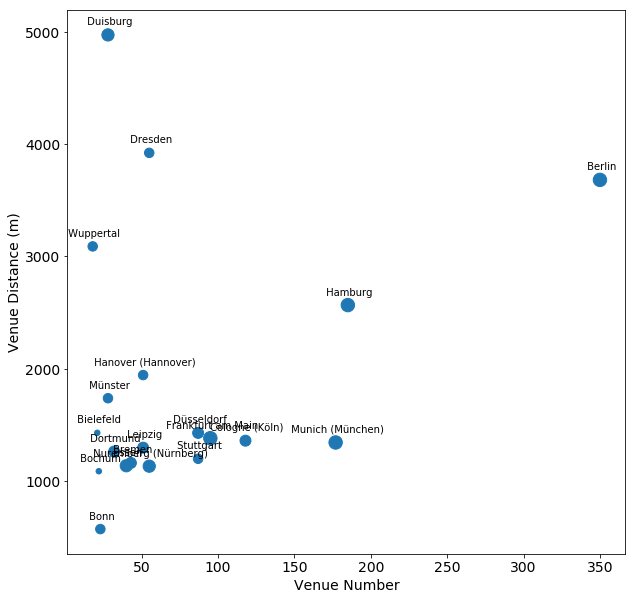

In [35]:
plt.figure(figsize = (10,10))
plt.scatter(finaldf['Venue Number'], finaldf['Median Distance'], s=(finaldf['Diversity score']-3)*30)
plt.xlabel('Venue Number', fontsize = 14)
plt.ylabel('Venue Distance (m)', fontsize = 14)
xs = finaldf['Venue Number']
ys =  finaldf['Median Distance']
ls = finaldf.index
for x,y,l in zip(xs,ys,ls):
    # this method is called for each point
    plt.annotate(l, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

## Calculate the final score for each city

In [37]:
# Normalise the data 
ss = StandardScaler()
X = ss.fit(finaldf).transform(finaldf)

C:\Users\schuetzenberger\AppData\Local\Continuum\anaconda2\envs\Python37\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\schuetzenberger\AppData\Local\Continuum\anaconda2\envs\Python37\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
# Calculate the final score 
y = X[:,1] + X[:,3] - X[:,2] - 0.2*X[:,1]
y = y - y.min()
finaldf['Final Score'] = y 

In [40]:
# Sort the DF by the final score
finaldfsorted = finaldf.sort_values('Final Score', ascending = False)

(array([0., 1., 2., 3., 4., 5., 6.]), <a list of 7 Text yticklabel objects>)

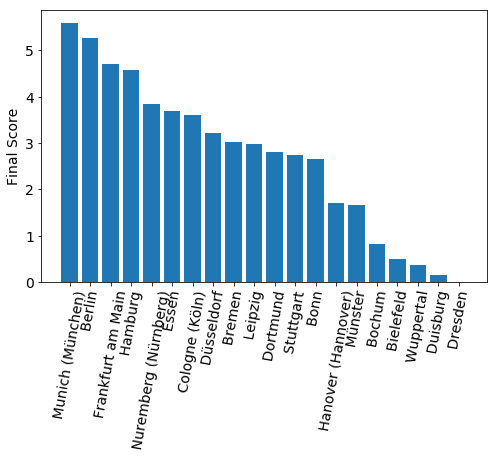

In [41]:
# Visualize the final ranking
plt.figure(figsize = (8,5))
plt.bar(finaldfsorted.index.values, finaldfsorted['Final Score'])
plt.xticks(rotation = 80)
plt.ylabel('Final Score', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [46]:
finaldfsorted

,2015 pop,Venue Number,Median Distance,Diversity score,Final Score
Munich (München),1450381.0,177,1342.0,9,5.586356
Berlin,3520031.0,350,3679.5,9,5.275385
Frankfurt am Main,732688.0,95,1380.0,9,4.714680
Hamburg,1787408.0,185,2565.0,9,4.580506
Nuremberg (Nürnberg),509975.0,55,1131.0,8,3.844996
Essen,582624.0,40,1135.0,8,3.688168
Cologne (Köln),1060582.0,118,1358.0,7,3.604478
Düsseldorf,612178.0,87,1427.0,7,3.226356
Bremen,557464.0,43,1160.0,7,3.014199
Leipzig,560472.0,51,1296.0,7,2.975001


## For the top city, Munich, visualize all venue on the city map

In [42]:
# exctract all venues in Munich from the df
mucvenues = res_city[res_city['City'] == '\xa0Munich (München)']

In [43]:
# get a color map with 9 colors
cmap = sns.hls_palette(9)
cmap = cmap.as_hex()

In [44]:
# show the map of Munich with all venues as markers, the different colors showing venues of different category
latitude = df.loc['\xa0Munich (München)', 'Latitude']
longitude = df.loc['\xa0Munich (München)', 'Longitude']
map_muc = folium.Map(location=[latitude, longitude], zoom_start=12)
i = -1
for c in categories:
    i +=1
    tempvenues = mucvenues[mucvenues['Category'] == c]
    for lat, lng, venue in zip(tempvenues['Latitude'], tempvenues['Longitude'], tempvenues['Name']):
        label = '{}'.format(venue)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=cmap[i],
            fill=True,
            fill_color=cmap[i],
            fill_opacity=0.7,
            parse_html=False).add_to(map_muc)  
    

map_muc

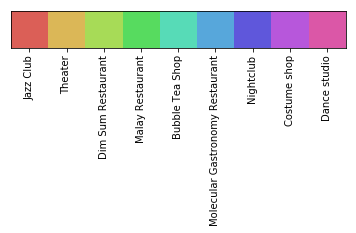

In [45]:
# create a legend for the map
cbar = np.arange(0,9,1)
cbar = np.tile(cbar, (1,1))
plt.imshow(cbar, ListedColormap(cmap))
plt.yticks([])
plt.xticks(np.arange(9), labels = category_names, rotation = 90);